Implementation of the Multiresolution Hash Encoding from the paper linked here:  https://github.com/NVlabs/instant-ngp
This notebook shows an example of how to use the 2D version of the method for encoding large images.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision.io import read_image
from PIL import Image


In [2]:
device = 'cuda'
# image from wikipedia:
# https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/1665_Girl_with_a_Pearl_Earring.jpg/1280px-1665_Girl_with_a_Pearl_Earring.jpg
img = read_image('1665_Girl_with_a_Pearl_Earring.jpg').to(device).float() / 255.0
img_size = torch.tensor( (img.shape[2], img.shape[1])).to(device)
print(img.shape)


torch.Size([3, 14550, 12285])


In [40]:
# get a batch of random (x, y) points within the unit square
# return the point cordinates and the target RGB values for each point
# return shape (nbatch, 3), (nbatch, 2)
def get_samples(img, nbatch=1024):
    iy = torch.randint(0, img.shape[1], (nbatch, ), device=device)
    ix = torch.randint(0, img.shape[2], (nbatch, ), device=device)
    x = torch.stack([ix, iy], dim=1)
    xnorm = x / img_size
    target_rgb = img[:, iy, ix].T
    return target_rgb, xnorm

In [41]:
# evaluate the model on a grid of points of size (Ny, Nx) to generate an image
# return the image as an np array of shape (Ny, Nx, 3)
def eval_image(model, Ny, Nx, device='cuda', crop=None):
    yy, xx = torch.meshgrid(torch.arange(Ny), torch.arange(Nx), indexing='ij')
    xpts = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)
    xnorm = xpts / torch.tensor([Nx, Ny], device=device)
    if crop is not None:
        xnorm[:, 0] *= (crop[2] - crop[0])
        xnorm[:, 0] += crop[0]
        xnorm[:, 1] *= (crop[3] - crop[1])
        xnorm[:, 1] += crop[1]
    rgb = model(xnorm)
    colors = rgb.detach().cpu().numpy()
    colors = np.clip(colors, 0, 1.0) * 255
    colors = colors.astype(np.uint8)
    colors = colors.reshape(Ny, Nx, -1)
    plt.imshow(colors)
    plt.axis('off')
    return colors

In [43]:
class HashEncoding(nn.Module):
    def __init__(self, Nmax, T, F):
        super().__init__()
        self.F = F
        self.Nmax = Nmax
        # if T > Nmax**2 then the embedding table is larger than it needs to be and the hashing is not needed
        self.use_hash = (T < Nmax**2)
        self.T = min(T, Nmax**2)
        self.embedding = nn.Embedding(self.T, F)
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)
    
    def _get_feature_vector(self, ix, iy):
        if self.use_hash:
            pi_1 = 2654435761
            hash_idx = torch.bitwise_xor(ix, iy * pi_1)
            hash_idx = torch.remainder(hash_idx, self.T)
        else:
            hash_idx = ix * self.Nmax + iy
            hash_idx = torch.remainder(hash_idx, self.T)
        return self.embedding(hash_idx) # shape (nbatch, F)
    
    def forward(self, xpts):
        xpts_scaled = xpts * self.Nmax
        corner_pt = xpts_scaled.floor()
        delta = xpts_scaled - corner_pt # offset from the upper left (between 0 and 1), shape (nbatch, 2)
        corner_idx = corner_pt.long()  # index of upper left corner
        # get feature vector associated with each of the 4 corners
        fv_ul = self._get_feature_vector(corner_idx[:, 0], corner_idx[:, 1])
        fv_ur = self._get_feature_vector(corner_idx[:, 0] + 1, corner_idx[:, 1])
        fv_ll = self._get_feature_vector(corner_idx[:, 0], corner_idx[:, 1] + 1)
        fv_lr = self._get_feature_vector(corner_idx[:, 0] + 1, corner_idx[:, 1] + 1)
        xfrac = delta[:, [0]]
        yfrac = delta[:, [1]]
        # bilinear interpolation of the feature vectors associated with the four corners of the cell
        fv_interp1 = xfrac * fv_lr + (1.0 - xfrac) * fv_ll
        fv_interp2 = xfrac * fv_ur + (1.0 - xfrac) * fv_ul
        fv_interp3 = yfrac * fv_interp1 + (1.0 - yfrac) * fv_interp2
        return fv_interp3
    
    
class MultiResolutionHashEncoding(nn.Module):
    def __init__(self, Nls, T, F):
        super().__init__()
        self.T = T
        self.F = F
        self.Nls = Nls
        self.L = len(Nls)
        self.hash_encodings = nn.ModuleList()
        self.mlp = nn.Sequential(
            nn.Linear(self.L * self.F, 64),
             nn.ReLU(),
             nn.Linear(64, 64),
             nn.ReLU(),
             nn.Linear(64, 3))
        
        for Nl in Nls:
            he = HashEncoding(Nl, T, F)
            self.hash_encodings.append(he)
        
    def forward(self, xpts):
        # each level will output a tensor of shape (nbatch, F).  They will be concatenated into a tensor of shape (nbatch, L * F)
        feature_vector = torch.cat([he(xpts) for he in self.hash_encodings], dim=1)  # (nbatch, L * F)
        # The MLP will map (nbatch, L * F) feature vector to (nbatch, 3) RGB values for each sample
        rgb = self.mlp(feature_vector)
        return rgb
        

In [42]:
# using the same notation as the paper
b = 1.5             # grid size ratio
L = 16              # number of levels
Nmin = 16           # number of cells (in each dimension) of the coarsest level
T = 2 ** 20         # number of hash table entries per level
F = 2               # dimension of each feature vector

# number of cells (in each dimension) for each level
Nls = np.floor(Nmin * (b ** np.arange(0, L))).astype(int)
print(Nls)

mrhe = MultiResolutionHashEncoding(Nls, T, F).to(device)

num_params = sum([p.numel() for p in mrhe.parameters()])
num_bytes = img.numel()
ratio = 4 * num_params / num_bytes
print(f'{ratio=}')

# number of cells over number of entries in hash table for each level
hash_ratio = Nls**2 / T
print(hash_ratio)

[  16   24   36   54   81  121  182  273  410  615  922 1383 2075 3113
 4670 7006]
ratio=0.10109530569553479
[2.44140625e-04 5.49316406e-04 1.23596191e-03 2.78091431e-03
 6.25705719e-03 1.39627457e-02 3.15895081e-02 7.10763931e-02
 1.60312653e-01 3.60703468e-01 8.10703278e-01 1.82408237e+00
 4.10616398e+00 9.24183750e+00 2.07985878e+01 4.68101845e+01]


In [8]:
optim = torch.optim.Adam(params=mrhe.parameters(), eps=1e-15, lr=0.01)
    

In [9]:
for i in range(20001):
    optim.zero_grad()
    target_rgb, xnorm = get_samples(img, nbatch=2048)
    pred_rgb = mrhe(xnorm)
    loss = torch.mean((target_rgb - pred_rgb) ** 2)
    loss.backward()
    optim.step()
    if i % 1000 == 0:
        mse = loss.item()
        psnr = -10 * np.log10(mse)
        print(f'{i}, {mse=:.05f}, {psnr=:.01f}')


0, mse=0.10637, psnr=9.7
1000, mse=0.00181, psnr=27.4
2000, mse=0.00138, psnr=28.6
3000, mse=0.00118, psnr=29.3
4000, mse=0.00112, psnr=29.5
5000, mse=0.00127, psnr=29.0
6000, mse=0.00103, psnr=29.9
7000, mse=0.00111, psnr=29.5
8000, mse=0.00109, psnr=29.6
9000, mse=0.00084, psnr=30.8
10000, mse=0.00086, psnr=30.7
11000, mse=0.00090, psnr=30.4
12000, mse=0.00082, psnr=30.9
13000, mse=0.00085, psnr=30.7
14000, mse=0.00070, psnr=31.5
15000, mse=0.00065, psnr=31.9
16000, mse=0.00088, psnr=30.5
17000, mse=0.00075, psnr=31.3
18000, mse=0.00080, psnr=31.0
19000, mse=0.00066, psnr=31.8
20000, mse=0.00071, psnr=31.5


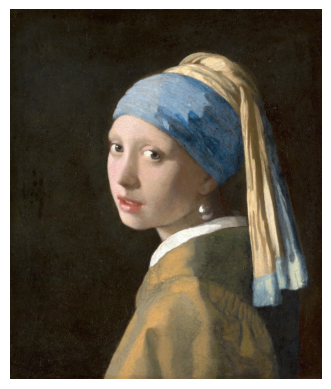

In [10]:
scale = 10
rgb = eval_image(mrhe, img.shape[1]//scale, img.shape[2]//scale)
img_pil = Image.fromarray(rgb)
img_pil.save('full.png')

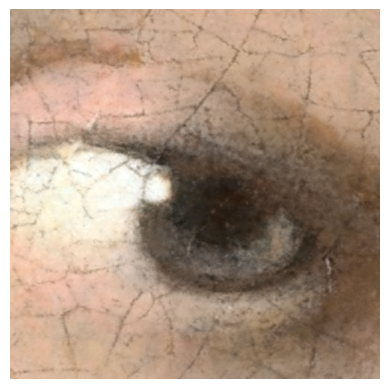

In [39]:

rgb = eval_image(mrhe, 600, 600, crop=(0.43, 0.36, 0.49, 0.42))
img_pil = Image.fromarray(rgb)
img_pil.save('zoom.png')

(-0.5, 12284.5, 2899.5, -0.5)

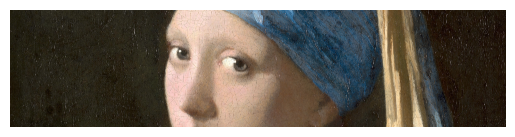

In [27]:
rgbs = []
scale = 100
dy = 1 / scale
Ny = img.shape[1] // scale
for iy in range(30, 50):
    rgbs.append(eval_image(mrhe, Ny, img.shape[2], crop=(0, iy * dy, 1, (iy + 1) * dy)))

rgb_all = np.concatenate(rgbs, axis=0)
plt.imshow(rgb_all)
plt.axis('off')

In [28]:

img_pil = Image.fromarray(rgb_all)
img_pil.save('fullsize.png')